In [1]:
import jax
import jax.numpy as jnp
import time
import ptyrodactyl.electrons as pte
import ptyrodactyl.tools as ptt
from jaxtyping import Array, Float, Shaped, Int, Complex
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
key = jax.random.PRNGKey(0)

In [5]:
beam_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)
slice_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)

beam_test_m = jax.random.normal(key, shape=(256, 256, 32), dtype=jnp.complex64)
slice_test_m = jax.random.normal(key, shape=(256, 256, 500), dtype=jnp.complex64)

In [6]:
def jax_test(a):
    b = a**2
    c = jnp.log10(b + a)
    return c

In [7]:
test_arr = 2.08
grad_func = jax.grad(jax_test)
jax_test(test_arr), grad_func(test_arr)

(Array(0.80661405, dtype=float64), Array(0.34980013, dtype=float64))

In [8]:
test_func_ss = jax.jit(pte.cbed)

In [9]:
%timeit pte.cbed(slice_test_s, beam_test_s, 1.0, 60.00, 0.1)

59.5 ms ± 531 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit test_func_ss(slice_test_s, beam_test_s, 1, 60.00, 0.1)

168 μs ± 2.54 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
beam_test_m.shape, slice_test_m.shape

((256, 256, 32), (256, 256, 500))

In [12]:
%timeit test_func_ss(slice_test_s, beam_test_m, 1, 60.00, 0.1)

374 μs ± 119 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit test_func_ss(slice_test_m, beam_test_s, 1, 60.00, 0.1)

20.9 ms ± 81.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit test_func_ss(slice_test_m, beam_test_m, 1, 60.00, 0.1)

347 ms ± 735 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
yy, xx = jnp.mgrid[-20:20, -20:20]
pos_list = jnp.transpose(jnp.array((yy.ravel(), xx.ravel())))
del yy, xx

In [16]:
devices = jax.devices()
devices

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

In [17]:
sharded_pot_slice = ptt.shard_array(
    jnp.atleast_3d(slice_test_s), shard_axes=[-1, -1, -1], devices=devices
)
sharded_beam = ptt.shard_array(
    jnp.atleast_3d(beam_test_s), shard_axes=[-1, -1, -1], devices=devices
)
sharded_pos_list = ptt.shard_array(pos_list, shard_axes=[-1, -1], devices=devices)

In [18]:
t = time.time()
pte.stem_4D(
    jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64),
    jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64),
    pos_list,
    1.00,
    jnp.asarray(60),
    0.1,
)
elapsed = time.time() - t
print(elapsed)

2.673372268676758


In [19]:
import numpy as np

In [20]:
test_data = np.load("../data/electrons/mos2_simul256.npz")
test_data.keys()

KeysView(NpzFile '../data/electrons/mos2_simul256.npz' with keys: data4D, probe_positions, probe, stem_images, ground_truth...)

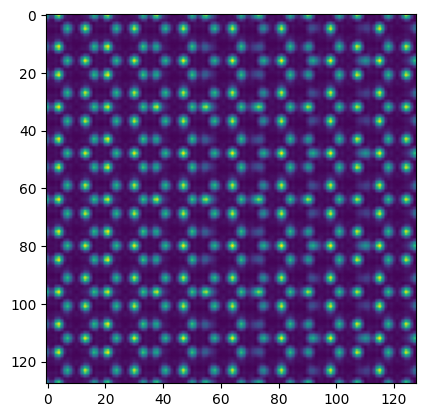

In [21]:
plt.imshow(test_data["stem_images"][:, :, 2])

In [22]:
for k in test_data.files:
    print(k)

data4D
probe_positions
probe
stem_images
ground_truth
defocus


In [28]:
data_4D = test_data["data4D"]
data_4Dr = jnp.asarray(data_4D.reshape(-1, data_4D.shape[2], data_4D.shape[3]))
probe_r = jnp.asarray(test_data["probe"])
positions_r = jnp.asarray(test_data["probe_positions"])
defocus = test_data["defocus"]

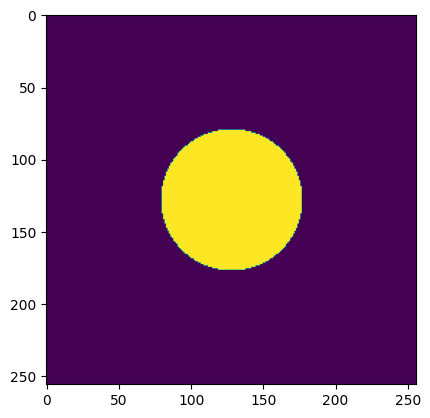

In [29]:
slice_guess = jnp.ones_like(probe_r)
plt.imshow(pte.cbed(slice_guess, probe_r, 1, 60, 0.2))

In [30]:
jax.jit(pte.stem_4D)(

<PjitFunction of <function stem_4D at 0x7f8c71359a80>>